In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam


#Librerías optimizacion por búsqueda aleatoria
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
maindf = pd.read_csv(r"/content/XAUUSD_D1.csv", sep="\t", parse_dates=["Time"], dayfirst=True)

In [4]:
maindf['Time'] = pd.to_datetime(maindf['Time'], format='%Y-%m-%d')

maindf = maindf.loc[(maindf['Time'] >= '2006-12-31')
                     & (maindf['Time'] <= '2022-12-01')]


In [5]:
# Separamos los valores de cierre
closedf = maindf[['Time','Close']]
print("Shape de closedf:", closedf.shape)

Shape de closedf: (4961, 2)


In [6]:
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  4961


In [7]:
del closedf['Time']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(4961, 1)


In [8]:
training_size=int(len(closedf)*0.75)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3720, 1)
test_data:  (1241, 1)


In [9]:
# Convierte un array de valores en un matriz dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 3
train_X, train_y = create_dataset(train_data, time_step)
test_X, test_y = create_dataset(test_data, time_step)

print("X_train: ", train_X.shape)
print("y_train: ", train_y.shape)
print("X_test: ", test_X.shape)
print("y_test", test_y.shape)

X_train:  (3716, 3)
y_train:  (3716,)
X_test:  (1237, 3)
y_test (1237,)


In [11]:
# reshape input to be [samples, time steps, features] which is required for LSTM
train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)

print("X_train: ", train_X.shape)
print("X_test: ", test_X.shape)

X_train:  (3716, 3, 1)
X_test:  (1237, 3, 1)


In [12]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.activations import tanh

def create_model(n_layers, n_neurons, dropout_rate, lr):
    model = Sequential()
    for i in range(n_layers):
      if i==0:
        model.add(LSTM(n_neurons, activation=tanh, input_shape=train_X.shape[1:], return_sequences=True))
      else:
        model.add(LSTM(n_neurons, activation=tanh, return_sequences=True))
      model.add(Dropout(dropout_rate))
    model.add(LSTM(n_neurons, activation=tanh))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
#Esta es la funcion objetivo que tengo en optimizacion bayesiana
from tensorflow.keras.callbacks import EarlyStopping

# Función para entrenar y evaluar el modelo con los hiperparámetros dados y devolver la pérdida
def objective(n_layers, dropout_rate, n_neurons, lr):
    # Convertir los valores de los hiperparámetros en los tipos adecuados
    n_layers = round(n_layers)
    n_neurons = round(n_neurons)
    # Crear el modelo con los hiperparámetros dados
    model = create_model(n_layers, dropout_rate, n_neurons, lr)
    # Entrenar el modelo con los datos de entrenamiento
    early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
    model.fit(train_X, train_y, epochs=100, validation_split=0.1, callbacks=[early_stop], verbose=0)
    # Evaluar el modelo en el conjunto de prueba
    loss = -model.evaluate(test_X, test_y, verbose=0)
    return loss

In [ ]:
# Definimos los límites de los hiperparámetros

param_dist = {
    'n_layers': sp_randint(1, 6),
    'n_neurons': sp_randint(32, 150),
    'dropout_rate': sp_uniform(loc=0.0, scale=0.99),
    'lr': sp_uniform(loc=1e-10, scale=1e-2)
}

In [ ]:
n_iter_search = 20
random_search = RandomizedSearchCV(estimator=KerasRegressor(build_fn=create_model), param_distributions=param_dist, n_iter=n_iter_search, cv=3)


<ipython-input-15-b904e0e7cb97>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  random_search = RandomizedSearchCV(estimator=KerasRegressor(build_fn=create_model), param_distributions=param_dist, n_iter=n_iter_search, cv=3)


In [ ]:
import joblib
# Esto ejecuta la celda en varios núcleos de CPU
with joblib.parallel_backend('multiprocessing', n_jobs=-1):
    random_search.fit(train_X, train_y)

39/39 [==============================] - 4s 9ms/step - loss: 0.0251


39/39 [==============================] - 1s 4ms/step - loss: 0.0180


39/39 [==============================] - 1s 4ms/step - loss: 0.0051


39/39 [==============================] - 4s 10ms/step - loss: 0.0010


39/39 [==============================] - 2s 6ms/step - loss: 2.5759e-04


23/39 [================>.............] - ETA: 0s - loss: 0.0036

39/39 [==============================] - 5s 25ms/step - loss: 0.0022


39/39 [==============================] - 6s 19ms/step - loss: 0.0761


39/39 [==============================] - 4s 21ms/step - loss: 1.2230e-04


39/39 [==============================] - 6s 16ms/step - loss: 0.0018


39/39 [==============================] - 3s 16ms/step - loss: 9.8363e-05


39/39 [==============================] - 3s 7ms/step - loss: 0.0639


39/39 [==============================] - 3s 9ms/step - loss: 0.0096


52/78 [===================>..........] - ETA: 0s - loss: 0.0760

39/39 [==============================] - 3s 5ms/step - loss: 0.0576


39/39 [==============================] - 3s 5ms/step - loss: 6.9077e-04


39/39 [==============================] - 2s 5ms/step - loss: 0.0016


78/78 [==============================] - 12s 13ms/step - loss: 0.0238


39/39 [==============================] - 3s 5ms/step - loss: 9.4868e-04


39/39 [==============================] - 2s 5ms/step - loss: 5.6810e-04


39/39 [==============================] - 4s 8ms/step - loss: 0.0936


39/39 [==============================] - 4s 8ms/step - loss: 0.0100


39/39 [==============================] - 5s 8ms/step - loss: 0.0020


39/39 [==============================] - 3s 18ms/step - loss: 0.0663


39/39 [==============================] - 3s 19ms/step - loss: 0.0103


39/39 [==============================] - 4s 22ms/step - loss: 8.5708e-05


39/39 [==============================] - 3s 7ms/step - loss: 0.0343


39/39 [==============================] - 2s 6ms/step - loss: 3.1541e-04


 3/78 [>.............................] - ETA: 2s - loss: 0.2854   

39/39 [==============================] - 2s 7ms/step - loss: 0.0091


39/39 [==============================] - 2s 10ms/step - loss: 5.6012e-04


39/39 [==============================] - 3s 9ms/step - loss: 1.6086e-04


39/39 [==============================] - 6s 13ms/step - loss: 0.0804


39/39 [==============================] - 6s 13ms/step - loss: 8.3519e-04


21/78 [=======>......................] - ETA: 2s - loss: 0.1084

39/39 [==============================] - 7s 11ms/step - loss: 1.2706e-04


39/39 [==============================] - 5s 10ms/step - loss: 0.0036


39/39 [==============================] - 3s 7ms/step - loss: 4.1106e-04


39/39 [==============================] - 2s 5ms/step - loss: 0.0287


39/39 [==============================] - 2s 5ms/step - loss: 0.0013


39/39 [==============================] - 3s 6ms/step - loss: 3.7593e-04


39/39 [==============================] - 4s 20ms/step - loss: 0.0874


39/39 [==============================] - 4s 17ms/step - loss: 0.0790


42/78 [===============>..............] - ETA: 0s - loss: 0.0747

39/39 [==============================] - 2s 5ms/step - loss: 0.0333


39/39 [==============================] - 2s 5ms/step - loss: 6.4059e-04


39/39 [==============================] - 2s 5ms/step - loss: 0.0022


39/39 [==============================] - 4s 20ms/step - loss: 0.0815


39/39 [==============================] - 4s 25ms/step - loss: 0.0121


39/39 [==============================] - 6s 26ms/step - loss: 7.9530e-04


39/39 [==============================] - 7s 20ms/step - loss: 0.0874


39/39 [==============================] - 4s 19ms/step - loss: 0.0018


39/39 [==============================] - 6s 23ms/step - loss: 0.0026


 9/39 [=====>........................] - ETA: 0s - loss: 0.0918  

39/39 [==============================] - 3s 6ms/step - loss: 0.0442


39/39 [==============================] - 2s 9ms/step - loss: 0.0117


 7/39 [====>.........................] - ETA: 0s - loss: 7.5926e-04 

39/39 [==============================] - 1s 7ms/step - loss: 5.3180e-04


117/117 [==============================] - 6s 14ms/step - loss: 0.0137


In [ ]:
print("Mejores parametros encontrados:", random_search.best_params_)
print("Mejor score encontrado:", random_search.best_score_)

Mejores parametros encontrados: {'dropout_rate': 0.37629871037966894, 'lr': 0.007128819207824817, 'n_layers': 1, 'n_neurons': 137}
Mejor score encontrado: -0.0032840033090906218


In [13]:
best_model_busq_aleatoria = create_model(int(random_search.best_params_['n_layers']),int(random_search.best_params_['n_neurons']),random_search.best_params_['dropout_rate'], random_search.best_params_['lr'])


In [14]:
best_model_busq_aleatoria.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 139)            78396     
                                                                 
 dropout (Dropout)           (None, 3, 139)            0         
                                                                 
 lstm_1 (LSTM)               (None, 139)               155124    
                                                                 
 dense (Dense)               (None, 1)                 140       
                                                                 
Total params: 233,660
Trainable params: 233,660
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = best_model_busq_aleatoria.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=1)


Epoch 1/100
117/117 [==============================] - 7s 22ms/step - loss: 0.0127 - val_loss: 2.4108e-04
Epoch 2/100
117/117 [==============================] - 2s 18ms/step - loss: 5.7151e-04 - val_loss: 2.0652e-04
Epoch 3/100
117/117 [==============================] - 3s 25ms/step - loss: 4.8614e-04 - val_loss: 2.1850e-04
Epoch 4/100
117/117 [==============================] - 2s 20ms/step - loss: 4.5844e-04 - val_loss: 3.7803e-04
Epoch 5/100
117/117 [==============================] - 2s 15ms/step - loss: 4.0428e-04 - val_loss: 2.9512e-04
Epoch 6/100
117/117 [==============================] - 2s 15ms/step - loss: 3.4439e-04 - val_loss: 2.0529e-04
Epoch 7/100
117/117 [==============================] - 2s 15ms/step - loss: 3.2050e-04 - val_loss: 2.1092e-04
Epoch 8/100
117/117 [==============================] - 2s 15ms/step - loss: 3.1356e-04 - val_loss: 5.3581e-04
Epoch 9/100
117/117 [==============================] - 2s 15ms/step - loss: 2.9358e-04 - val_loss: 2.1306e-04
Epoch 10/100
1

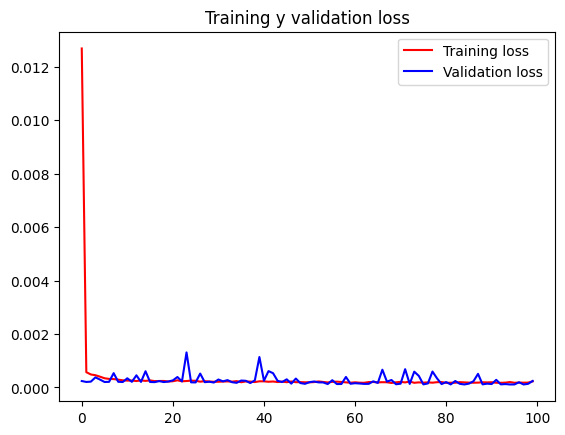

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training y validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=best_model_busq_aleatoria.predict(train_X)
test_predict=best_model_busq_aleatoria.predict(test_X)
train_predict.shape, test_predict.shape

39/39 [==============================] - 0s 5ms/step


((3716, 1), (1237, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
# Evaluation metrices RMSE, MAE and MAPE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MAPE: ", mape(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MAPE: ", mape(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  15.092387253510946
Train data MAPE:  0.9440017872550825
Train data MAE:  11.03521243690187
-------------------------------------------------------------------------------------
Test data RMSE:  22.796823915557066
Test data MAPE:  1.0687136462857523
Test data MAE:  18.52406891199727


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Precio original','Precio predecido Train','Precio predecido Test'])


plotdf = pd.DataFrame({'date': close_stock['Time'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Precio (USD)','date': 'Fecha'})
fig.update_layout(title_text='Comparación entre precio original de cierre y precio predecido de cierre',
                  plot_bgcolor='white', font_size=14, font_color='black', legend_title_text='Precio cierre')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (4961, 1)
Test predicted data:  (4961, 1)
